<a href="https://colab.research.google.com/github/janpeter19/BPL_YEAST_COB_Batch/blob/main/BPL_YEAST_COB_Batch_fmpy_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BPL_TEST2_Batch script with FMPy

The key library FMPy is installed.

After the installation a small application BPL_YEAST_COB_Batch is loaded and run. You can continue with this example if you like.

In [1]:
!lsb_release -a # Actual VM Ubuntu version used by Google

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.4 LTS
Release:	22.04
Codename:	jammy


In [2]:
%env PYTHONPATH=

env: PYTHONPATH=


In [3]:
!python --version

Python 3.11.11


In [4]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py311_24.11.1-0-Linux-x86_64.sh
!chmod +x Miniconda3-py311_24.11.1-0-Linux-x86_64.sh
!bash ./Miniconda3-py311_24.11.1-0-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.11/site-packages/')

--2025-02-08 10:17:39--  https://repo.anaconda.com/miniconda/Miniconda3-py311_24.11.1-0-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145900576 (139M) [application/octet-stream]
Saving to: ‘Miniconda3-py311_24.11.1-0-Linux-x86_64.sh’

Miniconda3-py311_24 100%[===================>] 139.14M   150MB/s    in 0.9s    

2025-02-08 10:17:40 (150 MB/s) - ‘Miniconda3-py311_24.11.1-0-Linux-x86_64.sh’ saved [145900576/145900576]

PREFIX=/usr/local
Unpacking payload ...

Installing base environment...

Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.


In [5]:
!conda update -n base -c defaults conda --yes

Channels:
 - defaults
Platform: linux-64
Solving environment: \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.12.31 |       h06a4308_0         128 KB
    certifi-2025.1.31          |  py311h06a4308_0         163 KB
    ------------------------------------------------------------
                                           Total:         291 KB

The following packages will be UPDATED:

  ca-certificates                     2024.11.26-h06a4308_0 --> 2024.12.31-h06a4308_0 
  certifi                         2024.8.30-py311h06a4308_0 --> 2025.1.31-py311h06a4308_0 



certifi-2025.1.31    | 163 KB    | :   0% 0/1 [00:00<?, ?it/s]
ca-certificates-2024 | 128 KB    | :   0% 0/1 [00:00<?, ?it/s]
certifi-2025.1.31    | 163 KB    | : 100% 1.0/1 [00:00<00:00, 11.80it/s]
   

In [6]:
!conda --version
!python --version

conda 24.11.1
Python 3.11.11


In [7]:
!conda config --set channel_priority strict

In [8]:
!conda install -c conda-forge fmpy --yes # Install the key package

Streaming output truncated to the last 5000 lines.

jupyterlab-4.3.5     | 7.3 MB    | :   0% 0/1 [00:00<?, ?it/s]

















babel-2.17.0         | 6.6 MB    | :   0% 0/1 [00:00<?, ?it/s]


















 ... (more hidden) ...
kaleido-core-0.2.1   | 59.2 MB   | :   0% 0.000263832842570537/1 [00:00<08:19, 499.95s/it]

qt-webengine-5.15.15 | 48.8 MB   | :   0% 0.0003204634953663842/1 [00:00<07:01, 421.93s/it]


libgoogle-cloud-2.12 | 41.5 MB   | :   0% 0.00037655075236030835/1 [00:00<06:07, 367.98s/it]



pillow-11.1.0        | 40.1 MB   | :   0% 0.00038989175173338107/1 [00:00<06:44, 404.40s/it]
kaleido-core-0.2.1   | 59.2 MB   | :   3% 0.03482593521931089/1 [00:00<00:05,  5.56s/it]  

qt-webengine-5.15.15 | 48.8 MB   | :   5% 0.04999230527715594/1 [00:00<00:03,  3.93s/it]   


libgoogle-cloud-2.12 | 41.5 MB   | :   7% 0.07041499069137766/1 [00:00<00:02,  2.81s/it]    



pillow-11.1.0        | 40.1 MB   | :   7% 0.07212997407067549/1 [00:00<00:02,  2.93s/it]    
kaleido-core-0

In [9]:
#!conda install matplotlib --yes

In [10]:
#!conda install scipy --yes

In [11]:
#!conda install xlrd --yes

In [12]:
#!conda install openpyxl --yes

In [13]:
# For some reason conda installation does not work for optlang
!pip install optlang

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 17.0 MB/s eta 0:00:00


# BPL_YEAST_COB_Batch setup


Now specific installation and the run simulations. Start with connecting to Github. Then upload the two files:

* FMU - BPL_YEAST_COB_Batch_linux_om_me.fmu
* Setup-file - BPL_YEAST_COB_Batch_fmpy_explore.py

In [14]:
%%bash
git clone https://github.com/janpeter19/BPL_YEAST_COB_Batch

Cloning into 'BPL_YEAST_COB_Batch'...


In [15]:
%cd BPL_YEAST_COB_Batch

/content/BPL_YEAST_COB_Batch


In [16]:
run -i BPL_YEAST_COB_Batch_fmpy_explore.py

Linux - run FMU pre-comiled OpenModelica

Model for bioreactor has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values/units

Note that both disp() and describe() takes values from the last simulation
and the command process_diagram() brings up the main configuration

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [17]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [25/2.54, 20/2.54]

In [18]:
import warnings
warnings.filterwarnings("ignore")

## BPL_YEAST_COB_Batch - demo



In [19]:
from optlang import Model, Variable, Constraint, Objective

No processDiagram.png file in the FMU, but try the file on disk.


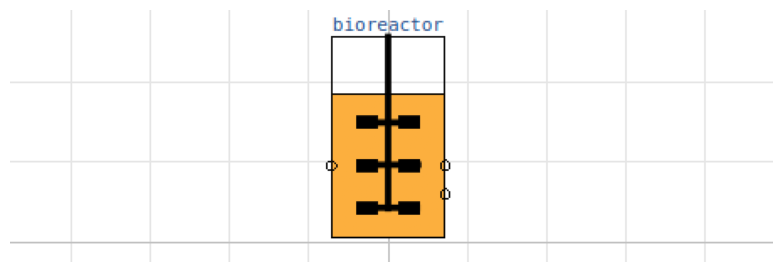

In [20]:
process_diagram()

In [21]:
describe('culture'); print(); #describe('liquidphase')                                  # Pump schedule parameter


Saccharomyces cerevisae - default parameters for strain H1022



In [22]:
# Define culture constraint-based model
def culture(G, E):

    # LP calculation of the optimal qGr, qEr based on G and E values

    # - parameters
    qO2max = 6.9e-3; kog = 2.3; koe = 1.6; YGr = 3.5; YEr = 1.32;
    alpha = 0.01; beta = 1.0

    # - transfer data from dynamic reactor model to static LP model
    qGr_opt = Variable('qGr_opt', lb=0)
    qEr_opt = Variable('qEr_opt', lb=0)

    # - LP model constraint and objective
    mu_max = Objective(YGr*qGr_opt + YEr*qEr_opt, direction='max')
    qO2lim = Constraint(kog*qGr_opt + koe*qEr_opt, ub=qO2max)
    qGlim = Constraint(qGr_opt, ub=alpha*max(0,G))
    qElim = Constraint(qEr_opt, ub=beta*max(0,E))

    # - put together the LP model
    yeast_model = Model(name='Yeast bottleneck model')
    yeast_model.objective = mu_max
    yeast_model.add(qO2lim)
    yeast_model.add(qGlim)
    yeast_model.add(qElim)

    # - do LP optimization
    yeast_model.optimize()

    return (yeast_model.objective.value, yeast_model.variables.qGr_opt.primal, yeast_model.variables.qEr_opt.primal, qO2lim.primal)

In [23]:
# Initialization
V_start=1.0
init(V_start=V_start, VX_start=V_start*2.0, VG_start=V_start*10, VE_start=V_start*3.0)

In [24]:
# Loop of simulations
t_final = 8.0
t_samp = 0.0333
n_samp = t_final/t_samp + 1

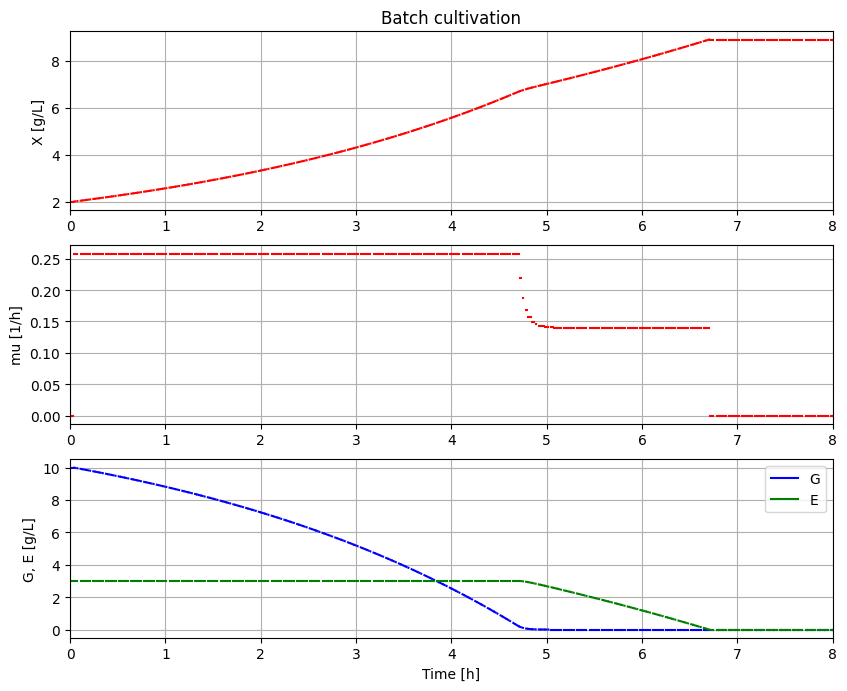

In [25]:
# Simulate n sample steps
newplot(title='Batch cultivation', plotType='TimeSeries2')
ax1.set_xlim([0, t_final]); ax2.set_xlim([0, t_final]); ax3.set_xlim([0, t_final])

simu(t_samp, options=opts_fast)
for i in range(int(n_samp)):
    (mum_opt, qGr_opt, qEr_opt, qO2_opt) = culture(sim_res['bioreactor.c[2]'][-1], sim_res['bioreactor.c[3]'][-1])
    par(mum=mum_opt, qGr=qGr_opt, qEr=qEr_opt, qO2=qO2_opt)
    simu(t_samp, 'cont', options=opts_fast)

In [26]:
system_info()


System information
 -OS: Linux
 -Python: 3.11.11
 -Scipy: not installed in the notebook
 -FMPy: 0.3.19
 -FMU by: OpenModelica Compiler OpenModelica 1.25.0~dev-133-ga5470be
 -FMI: 2.0
 -Type: ME
 -Name: BPL_YEAST_COB.Batch
 -Generated: 2024-11-08T08:21:20Z
 -MSL: 3.2.3
 -Description: Bioprocess Library version 2.3.0
 -Interaction: FMU-explore for FMPy version 1.0.1


In [27]:
!conda list optlang

Error while loading conda entry point: conda-libmamba-solver (libarchive.so.20: cannot open shared object file: No such file or directory)
# packages in environment at /usr/local:
#
# Name                    Version                   Build  Channel
optlang                   1.8.3                    pypi_0    pypi
